In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 

# Data

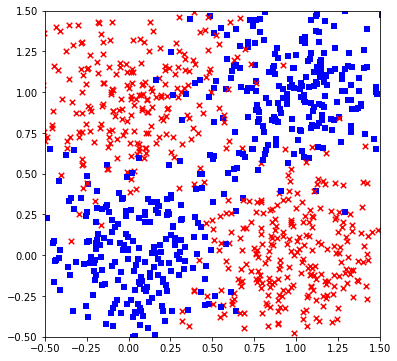

In [3]:

def getXORdata(sigma=0.1, number=1000):

    X = np.array([[0,0],[0,1],[1,0],[1,1]])
    t = np.array([[0],[1],[1],[0]])
    Xtmp = []
    ttmp = []
    for i in range(number):
        idx = np.random.randint(len(t))
        ttmp.append(t[idx])
        Xtmp.append(X[idx]+np.random.normal(scale=sigma,size=2))

    return np.asarray(Xtmp), np.asarray(ttmp)
    
X, t = getXORdata(sigma=0.3)

Xunif = []
grid = np.linspace(-1,2,100)
for x1 in grid:
    for x2 in grid:
        Xunif.append([x1,x2])
Xunif = np.asarray(Xunif)
    
def display(X, T, y=None, model=None):
    plt.figure(figsize=(6,6))
    if model is not None:
        ygrid = model.predict_proba(Xunif).round()
        tcolors = [int(i % 23) for i in ygrid]
        idxes = np.where(ygrid == 0)
        plt.scatter(Xunif[idxes,0], Xunif[idxes,1], s=10, c="black", alpha=0.6, marker='o', linewidths=0)
    #tcolors = [int(i % 23) for i in t]
    #markers = ['o' if i==0 else 'x' for i in ]
    for x,t in zip(X,T):
        plt.scatter(x[0], x[1], s=30, c='blue' if t==0 else 'red', marker='s' if t==0 else 'x', linewidths=0 if t==0 else 2)
    if y is not None:
        ycolors = [int(i % 23) for i in y]
        mistakes = np.where(T!=y)
        plt.scatter(X[mistakes,0], X[mistakes,1], s=20, c='yellow', marker='o')
        #plt.scatter(X[:,0], X[:,1], s=40, c=ycolors, marker='2')
    plt.xlim([-0.5,1.5])
    plt.ylim([-0.5,1.5])
    
        
        
display(X,t)


# Linear model

In [4]:
def build_linear_model():

    linmodel = Sequential()
    linmodel.add(Dense(32, input_dim=2, activation='linear', name='H1'))
    linmodel.add(Dense(1, activation='linear', name='Y'))

    opt = Adam()
    linmodel.compile(loss='binary_crossentropy', 
                optimizer=opt,
                metrics=['binary_accuracy'])

    linmodel.summary()
    return linmodel
build_linear_model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 32)                96        
_________________________________________________________________
Y (Dense)                    (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [5]:
#Train
#log = model.fit(X, t, nb_epoch=500)

def train(model, Xtrain, ttrain, Xvalid, tvalid, nb_epoch = 500, verbose = 0):
    log = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1,nb_epoch+1):
        loss, acc = model.train_on_batch(Xtrain,ttrain)
        log['loss'].append(loss)
        log['acc'].append(acc)
        val_loss, val_acc = model.test_on_batch(Xvalid,tvalid)
        log['val_loss'].append(val_loss)
        log['val_acc'].append(val_acc)
        if verbose == 0:
            print("Epoch %i/%i - loss: %.4f - accuracy: %.4f - val_loss: %.4f - val_accuracy: %.4f "%(epoch,nb_epoch,loss,acc,val_loss,val_acc))
        if epoch % 20 == 0 and verbose == 1:
            y = model.predict(Xtrain).round()
            display(Xtrain, ttrain, y=None, model=model)
            plt.title("Epoch: %i, loss: %.3f, val_loss: %.3f"%(epoch, loss, val_loss))
            plt.savefig("fig/"+str(epoch)+".png")
            
            #plt.show()
            
    return log

In [6]:
def cross_val_perf(cv=5):
    logs = []
    X, t = getXORdata(sigma=0.3)
    best_acc = 0.
    P = int(len(t)/cv)
    for r in range(cv):
        model = build_linear_model()
        idxes = range(r*P,(r+1)*P)
        mask = np.ones(t.shape, dtype=bool)
        mask[idxes] = False
        Xvalid = X[idxes]
        tvalid = t[idxes]
        Xtrain = np.asarray([x for i,x in enumerate(X) if i not in idxes])
        ttrain = np.asarray([x for i,x in enumerate(t) if i not in idxes])
        if r == 0:
            logs = train(model, Xtrain, ttrain, Xvalid, tvalid, verbose = 0)
        else:
            log = train(model, Xtrain, ttrain, Xvalid, tvalid)
            if log['val_acc'][-1] > best_acc:
                best_acc = log['val_acc'][-1]
                bestmodel = model
            for key, val in logs.items():
                logs[key] = np.vstack([val, log[key]])         
    return logs, bestmodel

linlogs, linmodel = cross_val_perf()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 32)                96        
_________________________________________________________________
Y (Dense)                    (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/500 - loss: 6.8136 - accuracy: 0.3875 - val_loss: 6.9733 - val_accuracy: 0.4050 
Epoch 2/500 - loss: 6.5755 - accuracy: 0.3963 - val_loss: 6.8397 - val_accuracy: 0.4050 
Epoch 3/500 - loss: 6.4058 - accuracy: 0.4112 - val_loss: 6.4300 - val_accuracy: 0.4350 
Epoch 4/500 - loss: 6.2961 - accuracy: 0.4137 - val_loss: 6.3611 - val_accuracy: 0.4400 
Epoch 5/500 - loss: 6.1530 - accuracy: 0.4288 - val_loss: 6.2741 - val_accuracy: 0.4500 
Epoch 6/500 - loss: 5.9925 - accuracy: 0.4387 -

Epoch 126/500 - loss: 0.7691 - accuracy: 0.5263 - val_loss: 0.7449 - val_accuracy: 0.5400 
Epoch 127/500 - loss: 0.7689 - accuracy: 0.5263 - val_loss: 0.7447 - val_accuracy: 0.5400 
Epoch 128/500 - loss: 0.7687 - accuracy: 0.5263 - val_loss: 0.7445 - val_accuracy: 0.5400 
Epoch 129/500 - loss: 0.7685 - accuracy: 0.5263 - val_loss: 0.7443 - val_accuracy: 0.5400 
Epoch 130/500 - loss: 0.7683 - accuracy: 0.5263 - val_loss: 0.7441 - val_accuracy: 0.5350 
Epoch 131/500 - loss: 0.7681 - accuracy: 0.5250 - val_loss: 0.7439 - val_accuracy: 0.5350 
Epoch 132/500 - loss: 0.7679 - accuracy: 0.5250 - val_loss: 0.7437 - val_accuracy: 0.5350 
Epoch 133/500 - loss: 0.7677 - accuracy: 0.5250 - val_loss: 0.7435 - val_accuracy: 0.5350 
Epoch 134/500 - loss: 0.7675 - accuracy: 0.5250 - val_loss: 0.7433 - val_accuracy: 0.5350 
Epoch 135/500 - loss: 0.7673 - accuracy: 0.5250 - val_loss: 0.7431 - val_accuracy: 0.5350 
Epoch 136/500 - loss: 0.7671 - accuracy: 0.5250 - val_loss: 0.7430 - val_accuracy: 0.5350 

Epoch 235/500 - loss: 0.7295 - accuracy: 0.5312 - val_loss: 0.7238 - val_accuracy: 0.5450 
Epoch 236/500 - loss: 0.7294 - accuracy: 0.5312 - val_loss: 0.7237 - val_accuracy: 0.5450 
Epoch 237/500 - loss: 0.7292 - accuracy: 0.5312 - val_loss: 0.7235 - val_accuracy: 0.5450 
Epoch 238/500 - loss: 0.7291 - accuracy: 0.5312 - val_loss: 0.7234 - val_accuracy: 0.5450 
Epoch 239/500 - loss: 0.7289 - accuracy: 0.5300 - val_loss: 0.7233 - val_accuracy: 0.5450 
Epoch 240/500 - loss: 0.7288 - accuracy: 0.5300 - val_loss: 0.7232 - val_accuracy: 0.5450 
Epoch 241/500 - loss: 0.7286 - accuracy: 0.5312 - val_loss: 0.7230 - val_accuracy: 0.5450 
Epoch 242/500 - loss: 0.7285 - accuracy: 0.5325 - val_loss: 0.7229 - val_accuracy: 0.5450 
Epoch 243/500 - loss: 0.7283 - accuracy: 0.5325 - val_loss: 0.7228 - val_accuracy: 0.5450 
Epoch 244/500 - loss: 0.7282 - accuracy: 0.5325 - val_loss: 0.7227 - val_accuracy: 0.5450 
Epoch 245/500 - loss: 0.7280 - accuracy: 0.5325 - val_loss: 0.7226 - val_accuracy: 0.5450 

Epoch 346/500 - loss: 0.7155 - accuracy: 0.5288 - val_loss: 0.7123 - val_accuracy: 0.5300 
Epoch 347/500 - loss: 0.7154 - accuracy: 0.5275 - val_loss: 0.7123 - val_accuracy: 0.5300 
Epoch 348/500 - loss: 0.7153 - accuracy: 0.5263 - val_loss: 0.7122 - val_accuracy: 0.5300 
Epoch 349/500 - loss: 0.7152 - accuracy: 0.5250 - val_loss: 0.7121 - val_accuracy: 0.5300 
Epoch 350/500 - loss: 0.7151 - accuracy: 0.5263 - val_loss: 0.7120 - val_accuracy: 0.5300 
Epoch 351/500 - loss: 0.7150 - accuracy: 0.5250 - val_loss: 0.7119 - val_accuracy: 0.5300 
Epoch 352/500 - loss: 0.7149 - accuracy: 0.5250 - val_loss: 0.7118 - val_accuracy: 0.5300 
Epoch 353/500 - loss: 0.7148 - accuracy: 0.5238 - val_loss: 0.7118 - val_accuracy: 0.5300 
Epoch 354/500 - loss: 0.7147 - accuracy: 0.5238 - val_loss: 0.7117 - val_accuracy: 0.5300 
Epoch 355/500 - loss: 0.7146 - accuracy: 0.5238 - val_loss: 0.7116 - val_accuracy: 0.5300 
Epoch 356/500 - loss: 0.7145 - accuracy: 0.5238 - val_loss: 0.7115 - val_accuracy: 0.5300 

Epoch 478/500 - loss: 0.7046 - accuracy: 0.5038 - val_loss: 0.7039 - val_accuracy: 0.5000 
Epoch 479/500 - loss: 0.7045 - accuracy: 0.5038 - val_loss: 0.7038 - val_accuracy: 0.5000 
Epoch 480/500 - loss: 0.7044 - accuracy: 0.5038 - val_loss: 0.7038 - val_accuracy: 0.5000 
Epoch 481/500 - loss: 0.7044 - accuracy: 0.5038 - val_loss: 0.7037 - val_accuracy: 0.5000 
Epoch 482/500 - loss: 0.7043 - accuracy: 0.5038 - val_loss: 0.7037 - val_accuracy: 0.5000 
Epoch 483/500 - loss: 0.7043 - accuracy: 0.5038 - val_loss: 0.7036 - val_accuracy: 0.5000 
Epoch 484/500 - loss: 0.7042 - accuracy: 0.5038 - val_loss: 0.7036 - val_accuracy: 0.5000 
Epoch 485/500 - loss: 0.7041 - accuracy: 0.5038 - val_loss: 0.7035 - val_accuracy: 0.5000 
Epoch 486/500 - loss: 0.7041 - accuracy: 0.5025 - val_loss: 0.7035 - val_accuracy: 0.5000 
Epoch 487/500 - loss: 0.7040 - accuracy: 0.5025 - val_loss: 0.7034 - val_accuracy: 0.5000 
Epoch 488/500 - loss: 0.7039 - accuracy: 0.5025 - val_loss: 0.7034 - val_accuracy: 0.5000 

Epoch 83/500 - loss: 0.7663 - accuracy: 0.3613 - val_loss: 0.7565 - val_accuracy: 0.3850 
Epoch 84/500 - loss: 0.7659 - accuracy: 0.3613 - val_loss: 0.7560 - val_accuracy: 0.3850 
Epoch 85/500 - loss: 0.7655 - accuracy: 0.3613 - val_loss: 0.7554 - val_accuracy: 0.3900 
Epoch 86/500 - loss: 0.7651 - accuracy: 0.3613 - val_loss: 0.7549 - val_accuracy: 0.3900 
Epoch 87/500 - loss: 0.7646 - accuracy: 0.3600 - val_loss: 0.7544 - val_accuracy: 0.3850 
Epoch 88/500 - loss: 0.7642 - accuracy: 0.3587 - val_loss: 0.7539 - val_accuracy: 0.3850 
Epoch 89/500 - loss: 0.7638 - accuracy: 0.3575 - val_loss: 0.7533 - val_accuracy: 0.3850 
Epoch 90/500 - loss: 0.7634 - accuracy: 0.3575 - val_loss: 0.7528 - val_accuracy: 0.3850 
Epoch 91/500 - loss: 0.7630 - accuracy: 0.3575 - val_loss: 0.7523 - val_accuracy: 0.3800 
Epoch 92/500 - loss: 0.7626 - accuracy: 0.3575 - val_loss: 0.7518 - val_accuracy: 0.3800 
Epoch 93/500 - loss: 0.7622 - accuracy: 0.3575 - val_loss: 0.7513 - val_accuracy: 0.3800 
Epoch 94/5

Epoch 199/500 - loss: 0.7300 - accuracy: 0.3500 - val_loss: 0.7168 - val_accuracy: 0.3750 
Epoch 200/500 - loss: 0.7297 - accuracy: 0.3500 - val_loss: 0.7166 - val_accuracy: 0.3750 
Epoch 201/500 - loss: 0.7295 - accuracy: 0.3500 - val_loss: 0.7164 - val_accuracy: 0.3750 
Epoch 202/500 - loss: 0.7293 - accuracy: 0.3500 - val_loss: 0.7161 - val_accuracy: 0.3750 
Epoch 203/500 - loss: 0.7290 - accuracy: 0.3500 - val_loss: 0.7159 - val_accuracy: 0.3750 
Epoch 204/500 - loss: 0.7288 - accuracy: 0.3500 - val_loss: 0.7157 - val_accuracy: 0.3750 
Epoch 205/500 - loss: 0.7285 - accuracy: 0.3500 - val_loss: 0.7155 - val_accuracy: 0.3750 
Epoch 206/500 - loss: 0.7283 - accuracy: 0.3500 - val_loss: 0.7153 - val_accuracy: 0.3750 
Epoch 207/500 - loss: 0.7281 - accuracy: 0.3500 - val_loss: 0.7150 - val_accuracy: 0.3750 
Epoch 208/500 - loss: 0.7278 - accuracy: 0.3500 - val_loss: 0.7148 - val_accuracy: 0.3750 
Epoch 209/500 - loss: 0.7276 - accuracy: 0.3500 - val_loss: 0.7146 - val_accuracy: 0.3750 

Epoch 313/500 - loss: 0.7083 - accuracy: 0.3587 - val_loss: 0.6983 - val_accuracy: 0.3700 
Epoch 314/500 - loss: 0.7082 - accuracy: 0.3587 - val_loss: 0.6982 - val_accuracy: 0.3700 
Epoch 315/500 - loss: 0.7080 - accuracy: 0.3587 - val_loss: 0.6981 - val_accuracy: 0.3700 
Epoch 316/500 - loss: 0.7079 - accuracy: 0.3587 - val_loss: 0.6980 - val_accuracy: 0.3700 
Epoch 317/500 - loss: 0.7077 - accuracy: 0.3587 - val_loss: 0.6979 - val_accuracy: 0.3700 
Epoch 318/500 - loss: 0.7076 - accuracy: 0.3575 - val_loss: 0.6978 - val_accuracy: 0.3700 
Epoch 319/500 - loss: 0.7075 - accuracy: 0.3575 - val_loss: 0.6977 - val_accuracy: 0.3750 
Epoch 320/500 - loss: 0.7073 - accuracy: 0.3575 - val_loss: 0.6976 - val_accuracy: 0.3750 
Epoch 321/500 - loss: 0.7072 - accuracy: 0.3575 - val_loss: 0.6975 - val_accuracy: 0.3750 
Epoch 322/500 - loss: 0.7071 - accuracy: 0.3575 - val_loss: 0.6974 - val_accuracy: 0.3750 
Epoch 323/500 - loss: 0.7069 - accuracy: 0.3587 - val_loss: 0.6973 - val_accuracy: 0.3750 

Epoch 447/500 - loss: 0.6958 - accuracy: 0.3738 - val_loss: 0.6900 - val_accuracy: 0.3950 
Epoch 448/500 - loss: 0.6958 - accuracy: 0.3738 - val_loss: 0.6900 - val_accuracy: 0.3950 
Epoch 449/500 - loss: 0.6957 - accuracy: 0.3738 - val_loss: 0.6900 - val_accuracy: 0.3950 
Epoch 450/500 - loss: 0.6956 - accuracy: 0.3738 - val_loss: 0.6899 - val_accuracy: 0.3950 
Epoch 451/500 - loss: 0.6956 - accuracy: 0.3750 - val_loss: 0.6899 - val_accuracy: 0.3950 
Epoch 452/500 - loss: 0.6955 - accuracy: 0.3762 - val_loss: 0.6899 - val_accuracy: 0.3950 
Epoch 453/500 - loss: 0.6955 - accuracy: 0.3775 - val_loss: 0.6899 - val_accuracy: 0.3950 
Epoch 454/500 - loss: 0.6954 - accuracy: 0.3775 - val_loss: 0.6898 - val_accuracy: 0.3950 
Epoch 455/500 - loss: 0.6954 - accuracy: 0.3775 - val_loss: 0.6898 - val_accuracy: 0.3950 
Epoch 456/500 - loss: 0.6953 - accuracy: 0.3775 - val_loss: 0.6898 - val_accuracy: 0.3950 
Epoch 457/500 - loss: 0.6953 - accuracy: 0.3775 - val_loss: 0.6898 - val_accuracy: 0.3950 

Epoch 54/500 - loss: 0.9633 - accuracy: 0.5150 - val_loss: 0.8704 - val_accuracy: 0.5700 
Epoch 55/500 - loss: 0.9486 - accuracy: 0.5150 - val_loss: 0.8592 - val_accuracy: 0.5700 
Epoch 56/500 - loss: 0.9360 - accuracy: 0.5150 - val_loss: 0.8496 - val_accuracy: 0.5700 
Epoch 57/500 - loss: 0.9252 - accuracy: 0.5150 - val_loss: 0.8413 - val_accuracy: 0.5700 
Epoch 58/500 - loss: 0.9158 - accuracy: 0.5150 - val_loss: 0.8341 - val_accuracy: 0.5700 
Epoch 59/500 - loss: 0.9077 - accuracy: 0.5150 - val_loss: 0.8278 - val_accuracy: 0.5700 
Epoch 60/500 - loss: 0.9005 - accuracy: 0.5150 - val_loss: 0.8223 - val_accuracy: 0.5700 
Epoch 61/500 - loss: 0.8940 - accuracy: 0.5150 - val_loss: 0.8174 - val_accuracy: 0.5700 
Epoch 62/500 - loss: 0.8883 - accuracy: 0.5150 - val_loss: 0.8129 - val_accuracy: 0.5700 
Epoch 63/500 - loss: 0.8831 - accuracy: 0.5150 - val_loss: 0.8090 - val_accuracy: 0.5700 
Epoch 64/500 - loss: 0.8785 - accuracy: 0.5150 - val_loss: 0.8054 - val_accuracy: 0.5700 
Epoch 65/5

Epoch 184/500 - loss: 0.7693 - accuracy: 0.5038 - val_loss: 0.7274 - val_accuracy: 0.5650 
Epoch 185/500 - loss: 0.7688 - accuracy: 0.5038 - val_loss: 0.7271 - val_accuracy: 0.5650 
Epoch 186/500 - loss: 0.7684 - accuracy: 0.5025 - val_loss: 0.7268 - val_accuracy: 0.5600 
Epoch 187/500 - loss: 0.7680 - accuracy: 0.5025 - val_loss: 0.7266 - val_accuracy: 0.5600 
Epoch 188/500 - loss: 0.7676 - accuracy: 0.5025 - val_loss: 0.7264 - val_accuracy: 0.5600 
Epoch 189/500 - loss: 0.7672 - accuracy: 0.5000 - val_loss: 0.7261 - val_accuracy: 0.5550 
Epoch 190/500 - loss: 0.7667 - accuracy: 0.5000 - val_loss: 0.7259 - val_accuracy: 0.5550 
Epoch 191/500 - loss: 0.7663 - accuracy: 0.4988 - val_loss: 0.7256 - val_accuracy: 0.5550 
Epoch 192/500 - loss: 0.7659 - accuracy: 0.4975 - val_loss: 0.7254 - val_accuracy: 0.5500 
Epoch 193/500 - loss: 0.7655 - accuracy: 0.4975 - val_loss: 0.7252 - val_accuracy: 0.5500 
Epoch 194/500 - loss: 0.7651 - accuracy: 0.4975 - val_loss: 0.7249 - val_accuracy: 0.5500 

Epoch 281/500 - loss: 0.7407 - accuracy: 0.4112 - val_loss: 0.7133 - val_accuracy: 0.4550 
Epoch 282/500 - loss: 0.7405 - accuracy: 0.4125 - val_loss: 0.7133 - val_accuracy: 0.4550 
Epoch 283/500 - loss: 0.7403 - accuracy: 0.4087 - val_loss: 0.7132 - val_accuracy: 0.4550 
Epoch 284/500 - loss: 0.7402 - accuracy: 0.4075 - val_loss: 0.7132 - val_accuracy: 0.4550 
Epoch 285/500 - loss: 0.7400 - accuracy: 0.4050 - val_loss: 0.7131 - val_accuracy: 0.4550 
Epoch 286/500 - loss: 0.7398 - accuracy: 0.4050 - val_loss: 0.7130 - val_accuracy: 0.4550 
Epoch 287/500 - loss: 0.7396 - accuracy: 0.4038 - val_loss: 0.7130 - val_accuracy: 0.4450 
Epoch 288/500 - loss: 0.7394 - accuracy: 0.4038 - val_loss: 0.7129 - val_accuracy: 0.4450 
Epoch 289/500 - loss: 0.7393 - accuracy: 0.4025 - val_loss: 0.7129 - val_accuracy: 0.4450 
Epoch 290/500 - loss: 0.7391 - accuracy: 0.3988 - val_loss: 0.7128 - val_accuracy: 0.4350 
Epoch 291/500 - loss: 0.7389 - accuracy: 0.3963 - val_loss: 0.7128 - val_accuracy: 0.4350 

Epoch 398/500 - loss: 0.7272 - accuracy: 0.3613 - val_loss: 0.7110 - val_accuracy: 0.3750 
Epoch 399/500 - loss: 0.7271 - accuracy: 0.3613 - val_loss: 0.7110 - val_accuracy: 0.3750 
Epoch 400/500 - loss: 0.7271 - accuracy: 0.3600 - val_loss: 0.7110 - val_accuracy: 0.3750 
Epoch 401/500 - loss: 0.7270 - accuracy: 0.3600 - val_loss: 0.7110 - val_accuracy: 0.3750 
Epoch 402/500 - loss: 0.7269 - accuracy: 0.3600 - val_loss: 0.7110 - val_accuracy: 0.3750 
Epoch 403/500 - loss: 0.7269 - accuracy: 0.3587 - val_loss: 0.7109 - val_accuracy: 0.3750 
Epoch 404/500 - loss: 0.7268 - accuracy: 0.3600 - val_loss: 0.7109 - val_accuracy: 0.3750 
Epoch 405/500 - loss: 0.7267 - accuracy: 0.3600 - val_loss: 0.7109 - val_accuracy: 0.3750 
Epoch 406/500 - loss: 0.7267 - accuracy: 0.3600 - val_loss: 0.7109 - val_accuracy: 0.3750 
Epoch 407/500 - loss: 0.7266 - accuracy: 0.3600 - val_loss: 0.7109 - val_accuracy: 0.3750 
Epoch 408/500 - loss: 0.7265 - accuracy: 0.3600 - val_loss: 0.7109 - val_accuracy: 0.3750 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 32)                96        
_________________________________________________________________
Y (Dense)                    (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500 - loss: 7.3152 - accuracy: 0.2950 - val_loss: 7.7230 - val_accuracy: 0.2600 
Epoch 2/500 - loss: 7.2690 - accuracy: 0.2962 - val_loss: 7.6154 - val_accuracy: 0.2700 
Epoch 3/500 - loss: 7.2176 - accuracy: 0.2962 - val_loss: 7.5330 - val_accuracy: 0.2700 
Epoch 4/500 - loss: 7.1208 - accuracy: 0.2950 - val_loss: 7.4040 - val_accuracy: 0.2700 
Epoch 5/500 - loss: 7.0489 - accuracy: 0.2962 - val_loss: 7.2171 - val_accuracy: 0.2700 
Epoch 6/500 - loss: 6.9239 - accuracy: 0.2975 - val_loss: 7.1341 - val_accuracy: 0.2700 
Epoch 

Epoch 113/500 - loss: 3.7902 - accuracy: 0.6288 - val_loss: 3.7534 - val_accuracy: 0.6000 
Epoch 114/500 - loss: 3.7742 - accuracy: 0.6288 - val_loss: 3.7503 - val_accuracy: 0.6000 
Epoch 115/500 - loss: 3.7570 - accuracy: 0.6300 - val_loss: 3.7475 - val_accuracy: 0.6000 
Epoch 116/500 - loss: 3.7316 - accuracy: 0.6313 - val_loss: 3.7430 - val_accuracy: 0.6050 
Epoch 117/500 - loss: 3.7064 - accuracy: 0.6325 - val_loss: 3.6871 - val_accuracy: 0.6100 
Epoch 118/500 - loss: 3.6869 - accuracy: 0.6413 - val_loss: 3.6783 - val_accuracy: 0.6100 
Epoch 119/500 - loss: 3.6548 - accuracy: 0.6450 - val_loss: 3.6179 - val_accuracy: 0.6200 
Epoch 120/500 - loss: 3.6493 - accuracy: 0.6488 - val_loss: 3.6104 - val_accuracy: 0.6250 
Epoch 121/500 - loss: 3.6189 - accuracy: 0.6513 - val_loss: 3.6052 - val_accuracy: 0.6250 
Epoch 122/500 - loss: 3.5903 - accuracy: 0.6513 - val_loss: 3.4898 - val_accuracy: 0.6300 
Epoch 123/500 - loss: 3.5545 - accuracy: 0.6525 - val_loss: 3.3215 - val_accuracy: 0.6350 

Epoch 214/500 - loss: 0.7101 - accuracy: 0.6388 - val_loss: 0.7003 - val_accuracy: 0.6750 
Epoch 215/500 - loss: 0.7100 - accuracy: 0.6388 - val_loss: 0.7001 - val_accuracy: 0.6750 
Epoch 216/500 - loss: 0.7098 - accuracy: 0.6363 - val_loss: 0.7000 - val_accuracy: 0.6750 
Epoch 217/500 - loss: 0.7097 - accuracy: 0.6338 - val_loss: 0.6999 - val_accuracy: 0.6750 
Epoch 218/500 - loss: 0.7096 - accuracy: 0.6325 - val_loss: 0.6998 - val_accuracy: 0.6750 
Epoch 219/500 - loss: 0.7094 - accuracy: 0.6325 - val_loss: 0.6997 - val_accuracy: 0.6750 
Epoch 220/500 - loss: 0.7093 - accuracy: 0.6325 - val_loss: 0.6996 - val_accuracy: 0.6750 
Epoch 221/500 - loss: 0.7091 - accuracy: 0.6325 - val_loss: 0.6995 - val_accuracy: 0.6750 
Epoch 222/500 - loss: 0.7090 - accuracy: 0.6325 - val_loss: 0.6995 - val_accuracy: 0.6750 
Epoch 223/500 - loss: 0.7089 - accuracy: 0.6325 - val_loss: 0.6994 - val_accuracy: 0.6750 
Epoch 224/500 - loss: 0.7088 - accuracy: 0.6325 - val_loss: 0.6993 - val_accuracy: 0.6750 

Epoch 316/500 - loss: 0.6999 - accuracy: 0.6363 - val_loss: 0.6936 - val_accuracy: 0.6750 
Epoch 317/500 - loss: 0.6999 - accuracy: 0.6363 - val_loss: 0.6936 - val_accuracy: 0.6700 
Epoch 318/500 - loss: 0.6998 - accuracy: 0.6363 - val_loss: 0.6935 - val_accuracy: 0.6700 
Epoch 319/500 - loss: 0.6997 - accuracy: 0.6363 - val_loss: 0.6935 - val_accuracy: 0.6700 
Epoch 320/500 - loss: 0.6997 - accuracy: 0.6363 - val_loss: 0.6934 - val_accuracy: 0.6700 
Epoch 321/500 - loss: 0.6996 - accuracy: 0.6363 - val_loss: 0.6934 - val_accuracy: 0.6700 
Epoch 322/500 - loss: 0.6995 - accuracy: 0.6375 - val_loss: 0.6934 - val_accuracy: 0.6700 
Epoch 323/500 - loss: 0.6995 - accuracy: 0.6375 - val_loss: 0.6933 - val_accuracy: 0.6700 
Epoch 324/500 - loss: 0.6994 - accuracy: 0.6375 - val_loss: 0.6933 - val_accuracy: 0.6700 
Epoch 325/500 - loss: 0.6993 - accuracy: 0.6375 - val_loss: 0.6933 - val_accuracy: 0.6700 
Epoch 326/500 - loss: 0.6993 - accuracy: 0.6375 - val_loss: 0.6932 - val_accuracy: 0.6700 

Epoch 431/500 - loss: 0.6943 - accuracy: 0.6438 - val_loss: 0.6912 - val_accuracy: 0.6800 
Epoch 432/500 - loss: 0.6943 - accuracy: 0.6425 - val_loss: 0.6912 - val_accuracy: 0.6850 
Epoch 433/500 - loss: 0.6942 - accuracy: 0.6425 - val_loss: 0.6912 - val_accuracy: 0.6900 
Epoch 434/500 - loss: 0.6942 - accuracy: 0.6425 - val_loss: 0.6912 - val_accuracy: 0.6900 
Epoch 435/500 - loss: 0.6942 - accuracy: 0.6425 - val_loss: 0.6912 - val_accuracy: 0.6900 
Epoch 436/500 - loss: 0.6941 - accuracy: 0.6425 - val_loss: 0.6911 - val_accuracy: 0.6900 
Epoch 437/500 - loss: 0.6941 - accuracy: 0.6425 - val_loss: 0.6911 - val_accuracy: 0.6900 
Epoch 438/500 - loss: 0.6941 - accuracy: 0.6438 - val_loss: 0.6911 - val_accuracy: 0.6900 
Epoch 439/500 - loss: 0.6940 - accuracy: 0.6438 - val_loss: 0.6911 - val_accuracy: 0.6900 
Epoch 440/500 - loss: 0.6940 - accuracy: 0.6438 - val_loss: 0.6911 - val_accuracy: 0.6900 
Epoch 441/500 - loss: 0.6940 - accuracy: 0.6438 - val_loss: 0.6911 - val_accuracy: 0.6900 

Epoch 48/500 - loss: 1.0350 - accuracy: 0.6087 - val_loss: 0.8640 - val_accuracy: 0.6200 
Epoch 49/500 - loss: 0.9601 - accuracy: 0.6037 - val_loss: 0.8394 - val_accuracy: 0.5900 
Epoch 50/500 - loss: 0.8757 - accuracy: 0.5888 - val_loss: 0.8246 - val_accuracy: 0.5800 
Epoch 51/500 - loss: 0.8177 - accuracy: 0.5688 - val_loss: 0.8144 - val_accuracy: 0.5700 
Epoch 52/500 - loss: 0.8002 - accuracy: 0.5525 - val_loss: 0.8071 - val_accuracy: 0.5500 
Epoch 53/500 - loss: 0.7729 - accuracy: 0.5375 - val_loss: 0.8020 - val_accuracy: 0.5500 
Epoch 54/500 - loss: 0.7632 - accuracy: 0.5213 - val_loss: 0.7441 - val_accuracy: 0.5500 
Epoch 55/500 - loss: 0.7563 - accuracy: 0.5125 - val_loss: 0.7340 - val_accuracy: 0.5350 
Epoch 56/500 - loss: 0.7513 - accuracy: 0.5038 - val_loss: 0.7297 - val_accuracy: 0.5250 
Epoch 57/500 - loss: 0.7477 - accuracy: 0.5013 - val_loss: 0.7271 - val_accuracy: 0.5250 
Epoch 58/500 - loss: 0.7452 - accuracy: 0.4963 - val_loss: 0.7256 - val_accuracy: 0.5300 
Epoch 59/5

Epoch 145/500 - loss: 0.7152 - accuracy: 0.4363 - val_loss: 0.7066 - val_accuracy: 0.4850 
Epoch 146/500 - loss: 0.7151 - accuracy: 0.4338 - val_loss: 0.7065 - val_accuracy: 0.4850 
Epoch 147/500 - loss: 0.7149 - accuracy: 0.4338 - val_loss: 0.7064 - val_accuracy: 0.4850 
Epoch 148/500 - loss: 0.7148 - accuracy: 0.4300 - val_loss: 0.7063 - val_accuracy: 0.4850 
Epoch 149/500 - loss: 0.7146 - accuracy: 0.4300 - val_loss: 0.7062 - val_accuracy: 0.4850 
Epoch 150/500 - loss: 0.7145 - accuracy: 0.4300 - val_loss: 0.7061 - val_accuracy: 0.4850 
Epoch 151/500 - loss: 0.7143 - accuracy: 0.4313 - val_loss: 0.7060 - val_accuracy: 0.4850 
Epoch 152/500 - loss: 0.7142 - accuracy: 0.4300 - val_loss: 0.7059 - val_accuracy: 0.4800 
Epoch 153/500 - loss: 0.7140 - accuracy: 0.4288 - val_loss: 0.7058 - val_accuracy: 0.4800 
Epoch 154/500 - loss: 0.7139 - accuracy: 0.4275 - val_loss: 0.7057 - val_accuracy: 0.4800 
Epoch 155/500 - loss: 0.7137 - accuracy: 0.4275 - val_loss: 0.7056 - val_accuracy: 0.4800 

Epoch 241/500 - loss: 0.7047 - accuracy: 0.3913 - val_loss: 0.6999 - val_accuracy: 0.4150 
Epoch 242/500 - loss: 0.7046 - accuracy: 0.3913 - val_loss: 0.6999 - val_accuracy: 0.4150 
Epoch 243/500 - loss: 0.7045 - accuracy: 0.3887 - val_loss: 0.6998 - val_accuracy: 0.4150 
Epoch 244/500 - loss: 0.7044 - accuracy: 0.3887 - val_loss: 0.6998 - val_accuracy: 0.4150 
Epoch 245/500 - loss: 0.7044 - accuracy: 0.3875 - val_loss: 0.6997 - val_accuracy: 0.4150 
Epoch 246/500 - loss: 0.7043 - accuracy: 0.3875 - val_loss: 0.6997 - val_accuracy: 0.4150 
Epoch 247/500 - loss: 0.7042 - accuracy: 0.3875 - val_loss: 0.6996 - val_accuracy: 0.4150 
Epoch 248/500 - loss: 0.7041 - accuracy: 0.3875 - val_loss: 0.6996 - val_accuracy: 0.4150 
Epoch 249/500 - loss: 0.7040 - accuracy: 0.3875 - val_loss: 0.6995 - val_accuracy: 0.4150 
Epoch 250/500 - loss: 0.7040 - accuracy: 0.3875 - val_loss: 0.6995 - val_accuracy: 0.4150 
Epoch 251/500 - loss: 0.7039 - accuracy: 0.3862 - val_loss: 0.6994 - val_accuracy: 0.4150 

Epoch 344/500 - loss: 0.6982 - accuracy: 0.3812 - val_loss: 0.6954 - val_accuracy: 0.4000 
Epoch 345/500 - loss: 0.6981 - accuracy: 0.3812 - val_loss: 0.6954 - val_accuracy: 0.4000 
Epoch 346/500 - loss: 0.6981 - accuracy: 0.3812 - val_loss: 0.6954 - val_accuracy: 0.4000 
Epoch 347/500 - loss: 0.6980 - accuracy: 0.3812 - val_loss: 0.6953 - val_accuracy: 0.4000 
Epoch 348/500 - loss: 0.6980 - accuracy: 0.3812 - val_loss: 0.6953 - val_accuracy: 0.4000 
Epoch 349/500 - loss: 0.6979 - accuracy: 0.3800 - val_loss: 0.6953 - val_accuracy: 0.4000 
Epoch 350/500 - loss: 0.6979 - accuracy: 0.3787 - val_loss: 0.6952 - val_accuracy: 0.4000 
Epoch 351/500 - loss: 0.6978 - accuracy: 0.3787 - val_loss: 0.6952 - val_accuracy: 0.4000 
Epoch 352/500 - loss: 0.6978 - accuracy: 0.3787 - val_loss: 0.6952 - val_accuracy: 0.4000 
Epoch 353/500 - loss: 0.6977 - accuracy: 0.3787 - val_loss: 0.6951 - val_accuracy: 0.4050 
Epoch 354/500 - loss: 0.6977 - accuracy: 0.3775 - val_loss: 0.6951 - val_accuracy: 0.4050 

Epoch 446/500 - loss: 0.6944 - accuracy: 0.3713 - val_loss: 0.6925 - val_accuracy: 0.3950 
Epoch 447/500 - loss: 0.6944 - accuracy: 0.3713 - val_loss: 0.6925 - val_accuracy: 0.3950 
Epoch 448/500 - loss: 0.6943 - accuracy: 0.3713 - val_loss: 0.6925 - val_accuracy: 0.3950 
Epoch 449/500 - loss: 0.6943 - accuracy: 0.3713 - val_loss: 0.6925 - val_accuracy: 0.3950 
Epoch 450/500 - loss: 0.6943 - accuracy: 0.3713 - val_loss: 0.6925 - val_accuracy: 0.4000 
Epoch 451/500 - loss: 0.6942 - accuracy: 0.3713 - val_loss: 0.6924 - val_accuracy: 0.4000 
Epoch 452/500 - loss: 0.6942 - accuracy: 0.3713 - val_loss: 0.6924 - val_accuracy: 0.4000 
Epoch 453/500 - loss: 0.6942 - accuracy: 0.3713 - val_loss: 0.6924 - val_accuracy: 0.4000 
Epoch 454/500 - loss: 0.6942 - accuracy: 0.3713 - val_loss: 0.6924 - val_accuracy: 0.4000 
Epoch 455/500 - loss: 0.6941 - accuracy: 0.3700 - val_loss: 0.6924 - val_accuracy: 0.4000 
Epoch 456/500 - loss: 0.6941 - accuracy: 0.3700 - val_loss: 0.6923 - val_accuracy: 0.4000 

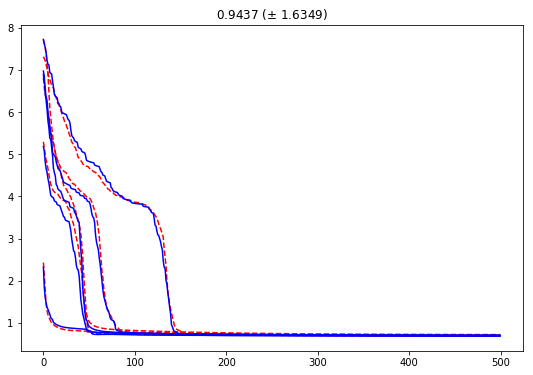

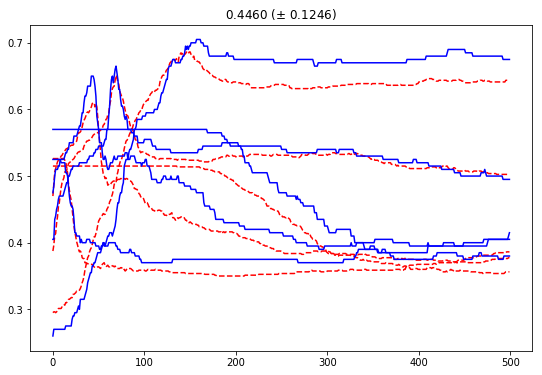

In [7]:
def plotPerf(logs):
    plt.figure(figsize=(9,6))
    plt.plot(logs['loss'].T, '--', c='red')
    plt.plot(logs['val_loss'].T, c='blue')
    plt.title('%.4f ($\pm$ %.4f)' % (np.mean(logs['val_loss'][-1]), 2*np.std(logs['val_loss'][-1])))
    
    plt.figure(figsize=(9,6))
    plt.plot(logs['acc'].T, '--', c='red')
    plt.plot(logs['val_acc'].T, c='blue')
    plt.title('%.4f ($\pm$ %.4f)' % (np.mean(logs['val_acc'][-1]), 2*np.std(logs['val_acc'][-1])))
    

plotPerf(linlogs)

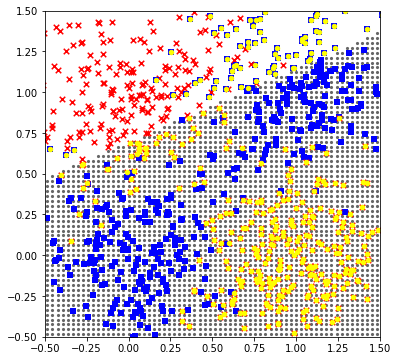

In [8]:
y = linmodel.predict_proba(X).round()

display(X,t,y,linmodel)


# Non linear model

In [9]:
def build_nonlinear_model():

    model = Sequential()
    model.add(Dense(64, input_dim=2, activation='relu', name='H1'))
    model.add(Dense(64, activation='relu', name='H2'))
    model.add(Dense(1, activation='sigmoid', name='Y'))

    opt = Adam()
    model.compile(loss='binary_crossentropy', 
                optimizer=opt,
                metrics=['binary_accuracy'])

    model.summary()
    return model
build_nonlinear_model()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                192       
_________________________________________________________________
H2 (Dense)                   (None, 64)                4160      
_________________________________________________________________
Y (Dense)                    (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [10]:
def cross_val_perf(cv=5):
    logs = []
    X, t = getXORdata(sigma=0.1)
    best_acc = 0.
    P = int(len(t)/cv)
    for r in range(cv):
        model = build_nonlinear_model()
        idxes = range(r*P,(r+1)*P)
        mask = np.ones(t.shape, dtype=bool)
        mask[idxes] = False
        Xvalid = X[idxes]
        tvalid = t[idxes]
        Xtrain = np.asarray([x for i,x in enumerate(X) if i not in idxes])
        ttrain = np.asarray([x for i,x in enumerate(t) if i not in idxes])
        if r == 0:
            logs = train(model, Xtrain, ttrain, Xvalid, tvalid)
        else:
            log = train(model, Xtrain, ttrain, Xvalid, tvalid)
            if log['val_acc'][-1] > best_acc:
                best_acc = log['val_acc'][-1]
                bestmodel = model
            for key, val in logs.items():
                logs[key] = np.vstack([val, log[key]])         
    return logs, bestmodel

logs, model = cross_val_perf()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                192       
_________________________________________________________________
H2 (Dense)                   (None, 64)                4160      
_________________________________________________________________
Y (Dense)                    (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500 - loss: 0.6877 - accuracy: 0.5800 - val_loss: 0.6835 - val_accuracy: 0.6650 
Epoch 2/500 - loss: 0.6842 - accuracy: 0.6513 - val_loss: 0.6798 - val_accuracy: 0.8700 
Epoch 3/500 - loss: 0.6804 - accuracy: 0.9050 - val_loss: 0.6760 - val_accuracy: 0.8800 
Epoch 4/500 - loss: 0.6766 - accuracy: 0.9150 - val_loss: 0.6724 - val_accuracy: 0.8950 
Epoch 5/500 - loss: 0.6729 - accuracy: 0.9200 - 

Epoch 105/500 - loss: 0.1154 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 1.0000 
Epoch 106/500 - loss: 0.1118 - accuracy: 1.0000 - val_loss: 0.1105 - val_accuracy: 1.0000 
Epoch 107/500 - loss: 0.1082 - accuracy: 1.0000 - val_loss: 0.1069 - val_accuracy: 1.0000 
Epoch 108/500 - loss: 0.1048 - accuracy: 1.0000 - val_loss: 0.1036 - val_accuracy: 1.0000 
Epoch 109/500 - loss: 0.1015 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 1.0000 
Epoch 110/500 - loss: 0.0983 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 1.0000 
Epoch 111/500 - loss: 0.0952 - accuracy: 1.0000 - val_loss: 0.0941 - val_accuracy: 1.0000 
Epoch 112/500 - loss: 0.0922 - accuracy: 1.0000 - val_loss: 0.0912 - val_accuracy: 1.0000 
Epoch 113/500 - loss: 0.0893 - accuracy: 1.0000 - val_loss: 0.0884 - val_accuracy: 1.0000 
Epoch 114/500 - loss: 0.0866 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 1.0000 
Epoch 115/500 - loss: 0.0839 - accuracy: 1.0000 - val_loss: 0.0830 - val_accuracy: 1.0000 

Epoch 208/500 - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000 
Epoch 209/500 - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 1.0000 
Epoch 210/500 - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 1.0000 
Epoch 211/500 - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 1.0000 
Epoch 212/500 - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000 
Epoch 213/500 - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 1.0000 
Epoch 214/500 - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 1.0000 
Epoch 215/500 - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 1.0000 
Epoch 216/500 - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000 
Epoch 217/500 - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000 
Epoch 218/500 - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000 

Epoch 310/500 - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 
Epoch 311/500 - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 
Epoch 312/500 - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 
Epoch 313/500 - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 314/500 - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 315/500 - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 316/500 - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 317/500 - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 318/500 - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 319/500 - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 320/500 - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000 

Epoch 422/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 
Epoch 423/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 
Epoch 424/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 
Epoch 425/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 
Epoch 426/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 427/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 428/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 429/500 - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 430/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 431/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 432/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 

Epoch 38/500 - loss: 0.5636 - accuracy: 0.9975 - val_loss: 0.5584 - val_accuracy: 1.0000 
Epoch 39/500 - loss: 0.5591 - accuracy: 0.9975 - val_loss: 0.5537 - val_accuracy: 1.0000 
Epoch 40/500 - loss: 0.5544 - accuracy: 0.9975 - val_loss: 0.5489 - val_accuracy: 1.0000 
Epoch 41/500 - loss: 0.5497 - accuracy: 0.9975 - val_loss: 0.5440 - val_accuracy: 1.0000 
Epoch 42/500 - loss: 0.5449 - accuracy: 0.9975 - val_loss: 0.5390 - val_accuracy: 1.0000 
Epoch 43/500 - loss: 0.5399 - accuracy: 0.9987 - val_loss: 0.5339 - val_accuracy: 1.0000 
Epoch 44/500 - loss: 0.5349 - accuracy: 0.9987 - val_loss: 0.5286 - val_accuracy: 1.0000 
Epoch 45/500 - loss: 0.5297 - accuracy: 0.9987 - val_loss: 0.5233 - val_accuracy: 1.0000 
Epoch 46/500 - loss: 0.5245 - accuracy: 0.9987 - val_loss: 0.5178 - val_accuracy: 1.0000 
Epoch 47/500 - loss: 0.5191 - accuracy: 0.9987 - val_loss: 0.5123 - val_accuracy: 1.0000 
Epoch 48/500 - loss: 0.5136 - accuracy: 1.0000 - val_loss: 0.5066 - val_accuracy: 1.0000 
Epoch 49/5

Epoch 146/500 - loss: 0.0424 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 1.0000 
Epoch 147/500 - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 1.0000 
Epoch 148/500 - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 1.0000 
Epoch 149/500 - loss: 0.0394 - accuracy: 1.0000 - val_loss: 0.0359 - val_accuracy: 1.0000 
Epoch 150/500 - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.0350 - val_accuracy: 1.0000 
Epoch 151/500 - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 1.0000 
Epoch 152/500 - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 1.0000 
Epoch 153/500 - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 1.0000 
Epoch 154/500 - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 1.0000 
Epoch 155/500 - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000 
Epoch 156/500 - loss: 0.0335 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 1.0000 

Epoch 240/500 - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000 
Epoch 241/500 - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000 
Epoch 242/500 - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000 
Epoch 243/500 - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000 
Epoch 244/500 - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 1.0000 
Epoch 245/500 - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000 
Epoch 246/500 - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 1.0000 
Epoch 247/500 - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000 
Epoch 248/500 - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000 
Epoch 249/500 - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000 
Epoch 250/500 - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000 

Epoch 356/500 - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 
Epoch 357/500 - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 
Epoch 358/500 - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 
Epoch 359/500 - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 
Epoch 360/500 - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 
Epoch 361/500 - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 
Epoch 362/500 - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 
Epoch 363/500 - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 
Epoch 364/500 - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000 
Epoch 365/500 - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000 
Epoch 366/500 - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000 

Epoch 453/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 
Epoch 454/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 
Epoch 455/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 
Epoch 456/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 
Epoch 457/500 - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 
Epoch 458/500 - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 
Epoch 459/500 - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000 
Epoch 460/500 - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000 
Epoch 461/500 - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000 
Epoch 462/500 - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000 
Epoch 463/500 - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000 

Epoch 37/500 - loss: 0.4992 - accuracy: 0.9875 - val_loss: 0.5010 - val_accuracy: 0.9800 
Epoch 38/500 - loss: 0.4934 - accuracy: 0.9875 - val_loss: 0.4950 - val_accuracy: 0.9800 
Epoch 39/500 - loss: 0.4874 - accuracy: 0.9875 - val_loss: 0.4890 - val_accuracy: 0.9800 
Epoch 40/500 - loss: 0.4815 - accuracy: 0.9875 - val_loss: 0.4829 - val_accuracy: 0.9800 
Epoch 41/500 - loss: 0.4754 - accuracy: 0.9887 - val_loss: 0.4768 - val_accuracy: 0.9800 
Epoch 42/500 - loss: 0.4693 - accuracy: 0.9887 - val_loss: 0.4705 - val_accuracy: 0.9850 
Epoch 43/500 - loss: 0.4631 - accuracy: 0.9887 - val_loss: 0.4642 - val_accuracy: 0.9900 
Epoch 44/500 - loss: 0.4568 - accuracy: 0.9887 - val_loss: 0.4578 - val_accuracy: 0.9900 
Epoch 45/500 - loss: 0.4504 - accuracy: 0.9900 - val_loss: 0.4513 - val_accuracy: 0.9900 
Epoch 46/500 - loss: 0.4440 - accuracy: 0.9900 - val_loss: 0.4447 - val_accuracy: 0.9950 
Epoch 47/500 - loss: 0.4375 - accuracy: 0.9912 - val_loss: 0.4381 - val_accuracy: 0.9950 
Epoch 48/5

Epoch 144/500 - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 1.0000 
Epoch 145/500 - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 1.0000 
Epoch 146/500 - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000 
Epoch 147/500 - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 1.0000 
Epoch 148/500 - loss: 0.0302 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 1.0000 
Epoch 149/500 - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 1.0000 
Epoch 150/500 - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 1.0000 
Epoch 151/500 - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 1.0000 
Epoch 152/500 - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000 
Epoch 153/500 - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.0271 - val_accuracy: 1.0000 
Epoch 154/500 - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.0265 - val_accuracy: 1.0000 

Epoch 250/500 - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000 
Epoch 251/500 - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000 
Epoch 252/500 - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000 
Epoch 253/500 - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000 
Epoch 254/500 - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000 
Epoch 255/500 - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000 
Epoch 256/500 - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000 
Epoch 257/500 - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000 
Epoch 258/500 - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000 
Epoch 259/500 - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000 
Epoch 260/500 - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000 

Epoch 356/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000 
Epoch 357/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000 
Epoch 358/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000 
Epoch 359/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000 
Epoch 360/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000 
Epoch 361/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000 
Epoch 362/500 - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 
Epoch 363/500 - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 
Epoch 364/500 - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 
Epoch 365/500 - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 
Epoch 366/500 - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 

Epoch 463/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 464/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 465/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 466/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 467/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 468/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 469/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 470/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 
Epoch 471/500 - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000 
Epoch 472/500 - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000 
Epoch 473/500 - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000 

Epoch 72/500 - loss: 0.2679 - accuracy: 1.0000 - val_loss: 0.2563 - val_accuracy: 1.0000 
Epoch 73/500 - loss: 0.2607 - accuracy: 1.0000 - val_loss: 0.2491 - val_accuracy: 1.0000 
Epoch 74/500 - loss: 0.2536 - accuracy: 1.0000 - val_loss: 0.2421 - val_accuracy: 1.0000 
Epoch 75/500 - loss: 0.2465 - accuracy: 1.0000 - val_loss: 0.2352 - val_accuracy: 1.0000 
Epoch 76/500 - loss: 0.2396 - accuracy: 1.0000 - val_loss: 0.2283 - val_accuracy: 1.0000 
Epoch 77/500 - loss: 0.2327 - accuracy: 1.0000 - val_loss: 0.2216 - val_accuracy: 1.0000 
Epoch 78/500 - loss: 0.2260 - accuracy: 1.0000 - val_loss: 0.2150 - val_accuracy: 1.0000 
Epoch 79/500 - loss: 0.2193 - accuracy: 1.0000 - val_loss: 0.2084 - val_accuracy: 1.0000 
Epoch 80/500 - loss: 0.2127 - accuracy: 1.0000 - val_loss: 0.2020 - val_accuracy: 1.0000 
Epoch 81/500 - loss: 0.2063 - accuracy: 1.0000 - val_loss: 0.1958 - val_accuracy: 1.0000 
Epoch 82/500 - loss: 0.2000 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 1.0000 
Epoch 83/5

Epoch 178/500 - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 1.0000 
Epoch 179/500 - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 1.0000 
Epoch 180/500 - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 1.0000 
Epoch 181/500 - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 1.0000 
Epoch 182/500 - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000 
Epoch 183/500 - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000 
Epoch 184/500 - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000 
Epoch 185/500 - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000 
Epoch 186/500 - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 1.0000 
Epoch 187/500 - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 1.0000 
Epoch 188/500 - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000 

Epoch 285/500 - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 
Epoch 286/500 - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 
Epoch 287/500 - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 288/500 - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 289/500 - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 290/500 - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 291/500 - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 292/500 - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000 
Epoch 293/500 - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000 
Epoch 294/500 - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000 
Epoch 295/500 - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000 

Epoch 391/500 - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 392/500 - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 393/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 394/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 
Epoch 395/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 
Epoch 396/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 
Epoch 397/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 
Epoch 398/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 
Epoch 399/500 - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 
Epoch 400/500 - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 
Epoch 401/500 - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 

Epoch 491/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 492/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 493/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 494/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 495/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 496/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 497/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 498/500 - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 499/500 - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
Epoch 500/500 - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 
_________________________________________________________________
Layer (type)            

Epoch 105/500 - loss: 0.0901 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 1.0000 
Epoch 106/500 - loss: 0.0872 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 1.0000 
Epoch 107/500 - loss: 0.0843 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 1.0000 
Epoch 108/500 - loss: 0.0815 - accuracy: 1.0000 - val_loss: 0.0874 - val_accuracy: 1.0000 
Epoch 109/500 - loss: 0.0789 - accuracy: 1.0000 - val_loss: 0.0847 - val_accuracy: 1.0000 
Epoch 110/500 - loss: 0.0763 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 1.0000 
Epoch 111/500 - loss: 0.0739 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 1.0000 
Epoch 112/500 - loss: 0.0715 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 1.0000 
Epoch 113/500 - loss: 0.0692 - accuracy: 1.0000 - val_loss: 0.0749 - val_accuracy: 1.0000 
Epoch 114/500 - loss: 0.0671 - accuracy: 1.0000 - val_loss: 0.0727 - val_accuracy: 1.0000 
Epoch 115/500 - loss: 0.0650 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 1.0000 

Epoch 209/500 - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 1.0000 
Epoch 210/500 - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000 
Epoch 211/500 - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 1.0000 
Epoch 212/500 - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 1.0000 
Epoch 213/500 - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 1.0000 
Epoch 214/500 - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000 
Epoch 215/500 - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000 
Epoch 216/500 - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000 
Epoch 217/500 - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000 
Epoch 218/500 - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000 
Epoch 219/500 - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000 

Epoch 313/500 - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 314/500 - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 315/500 - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 
Epoch 316/500 - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 317/500 - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 318/500 - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 319/500 - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000 
Epoch 320/500 - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000 
Epoch 321/500 - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000 
Epoch 322/500 - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000 
Epoch 323/500 - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000 

Epoch 418/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 419/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 420/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 421/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 422/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 423/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 424/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 425/500 - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 426/500 - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 
Epoch 427/500 - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 
Epoch 428/500 - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 

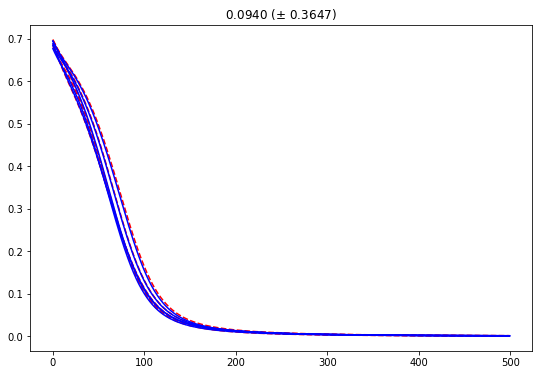

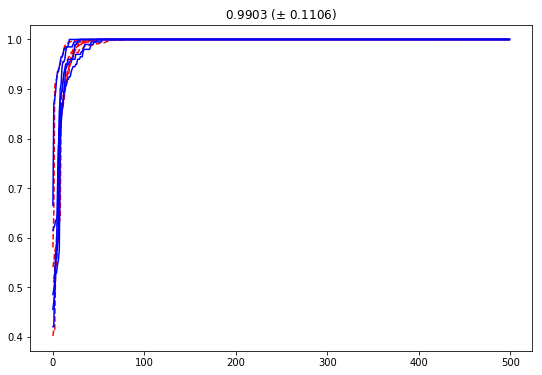

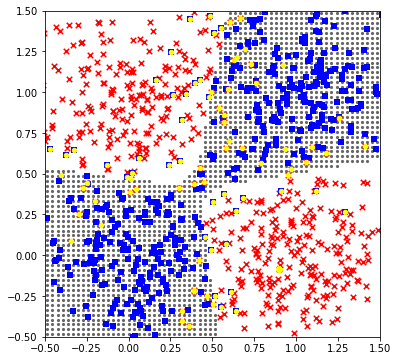

In [11]:
plotPerf(logs)

y = model.predict_proba(X).round()

display(X,t,y, model)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                192       
_________________________________________________________________
H2 (Dense)                   (None, 64)                4160      
_________________________________________________________________
Y (Dense)                    (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


C:\Users\Vincent\Anaconda3\envs\cs456env\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


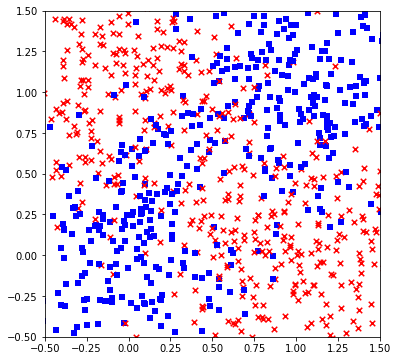

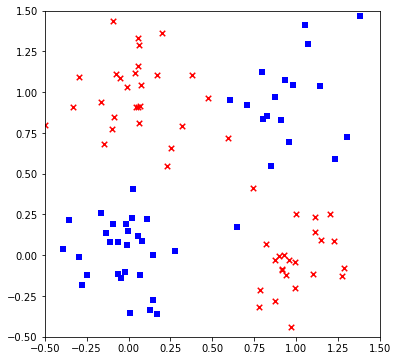

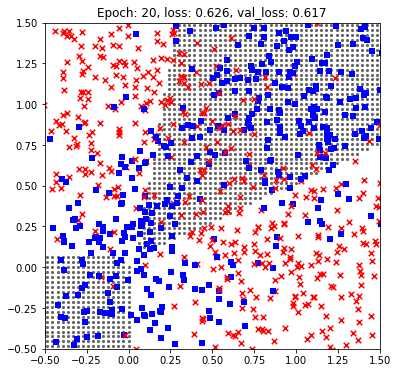

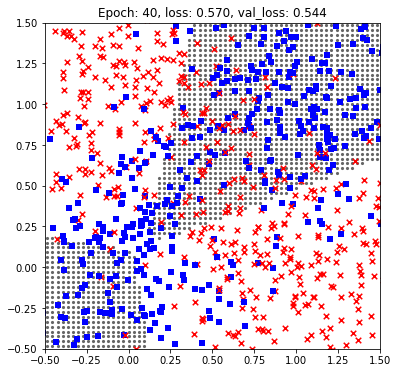

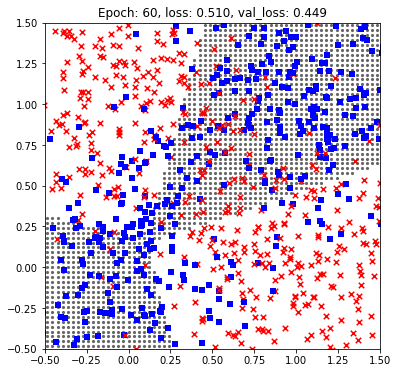

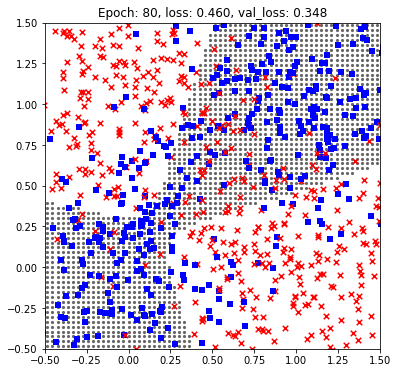

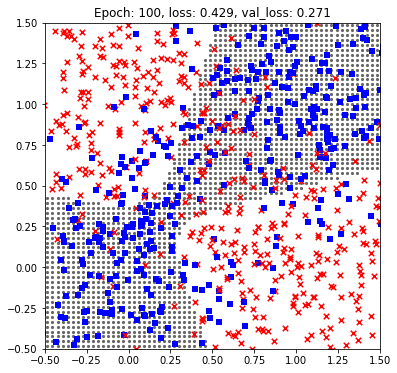

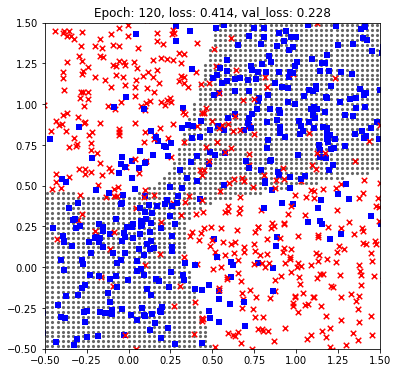

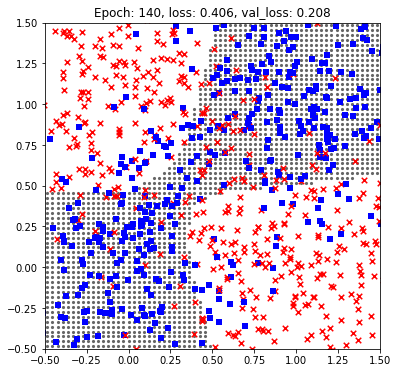

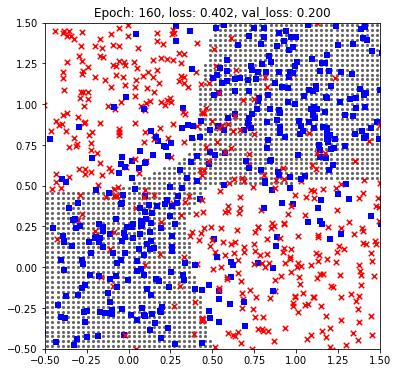

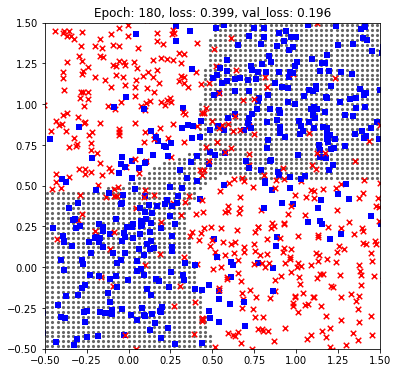

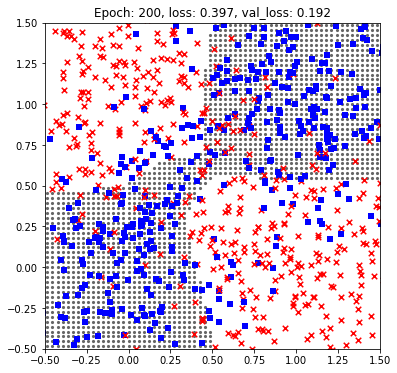

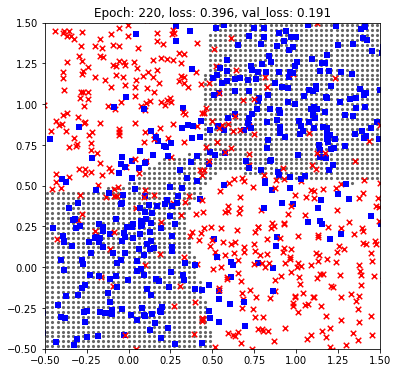

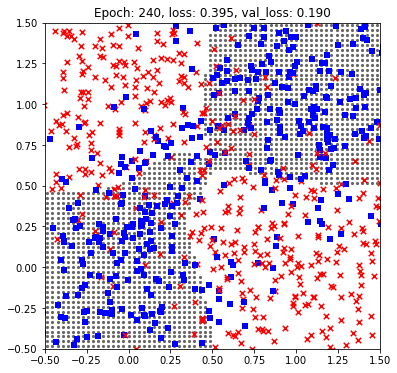

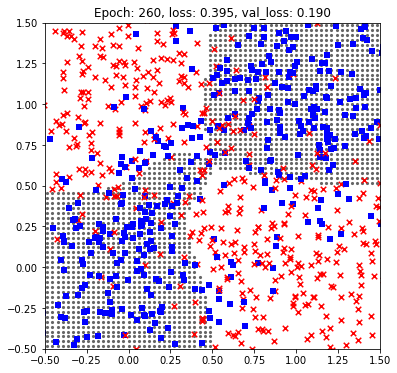

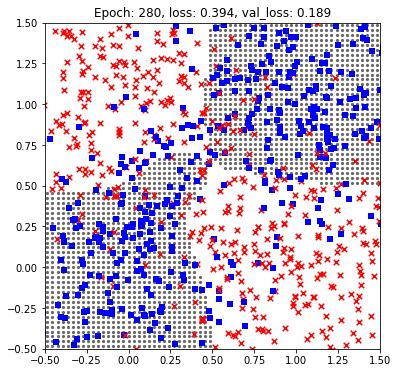

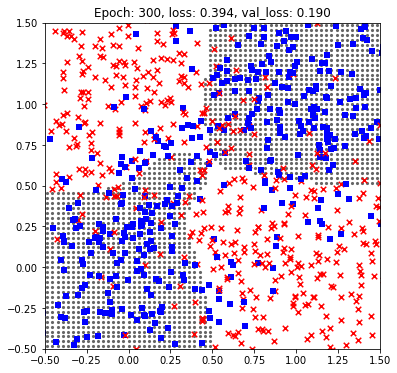

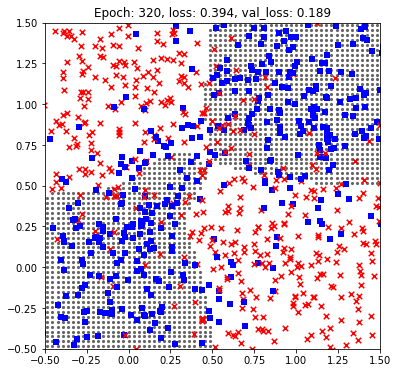

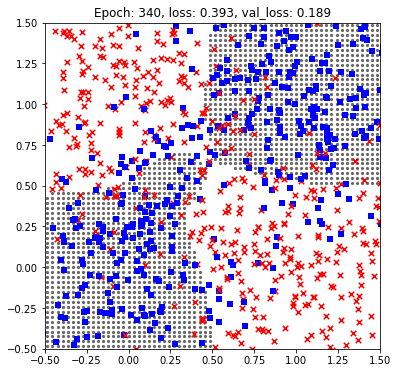

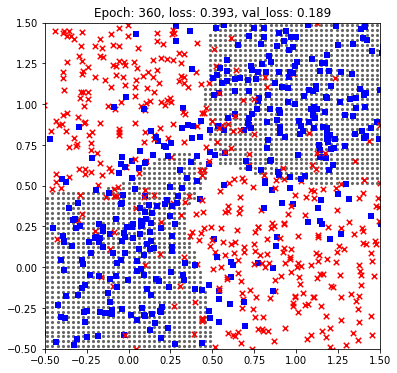

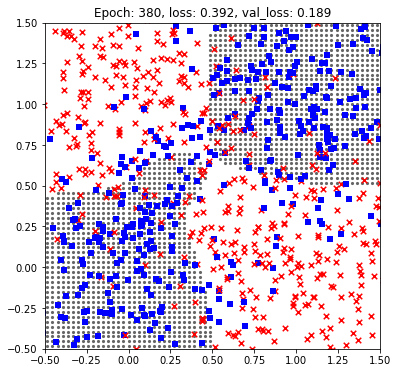

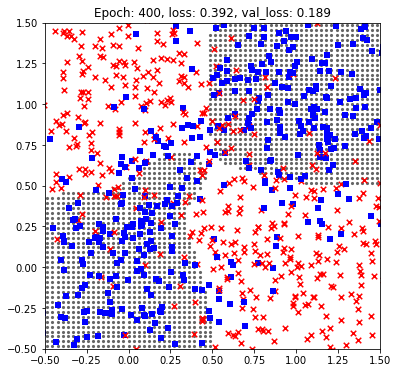

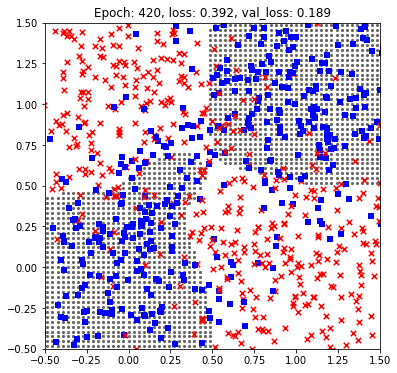

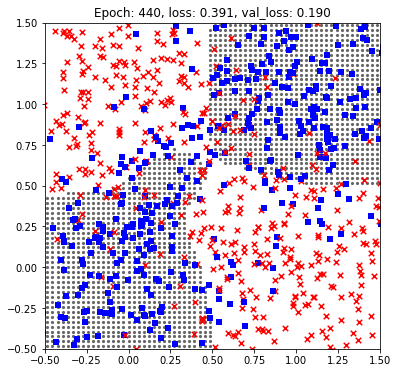

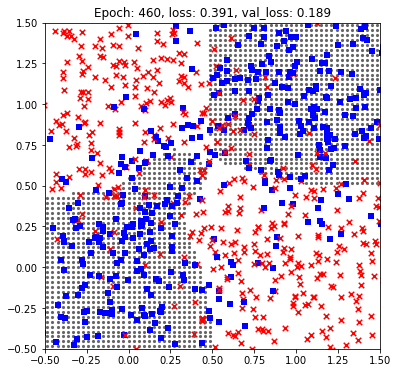

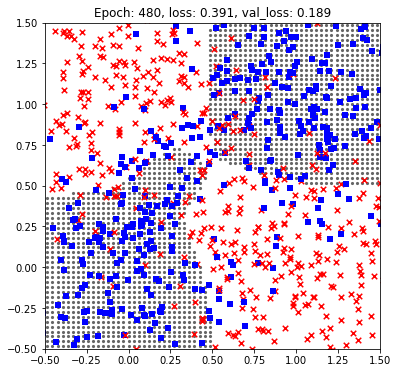

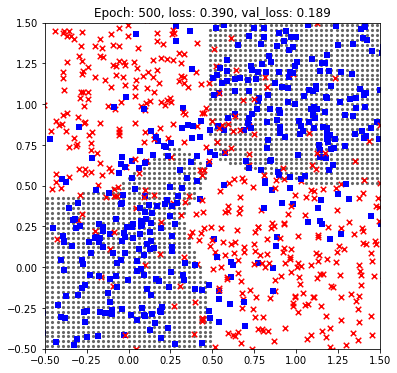

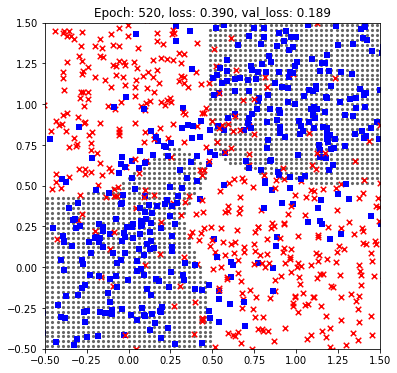

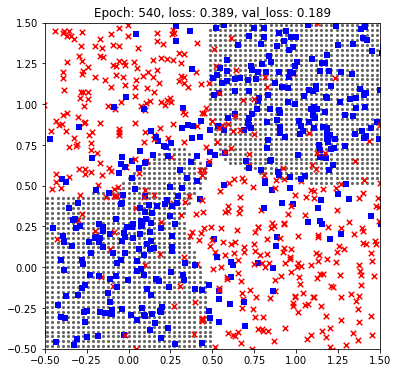

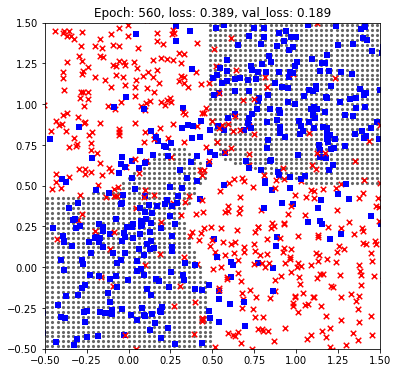

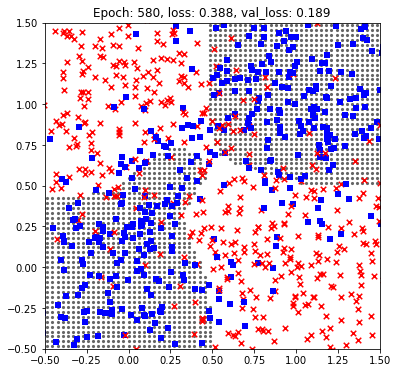

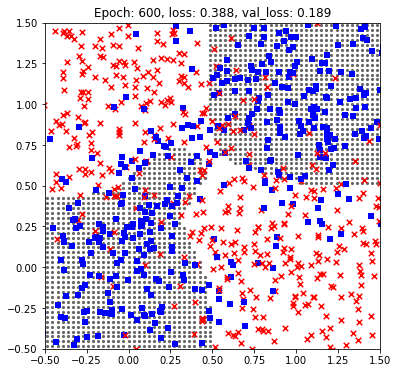

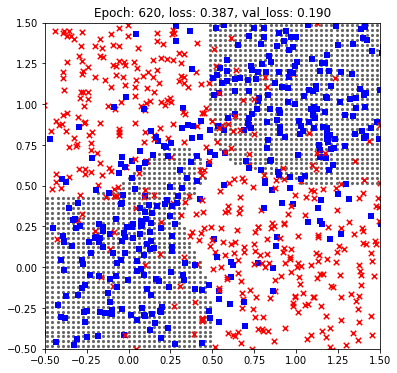

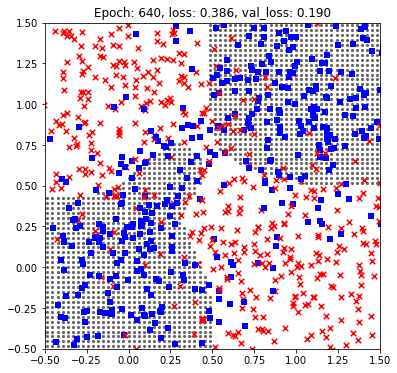

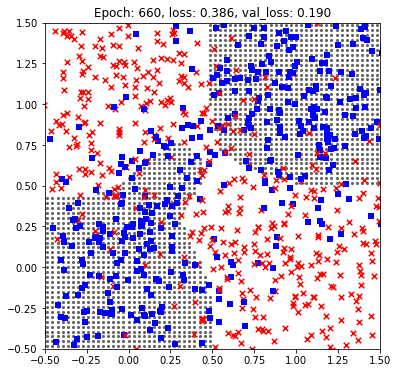

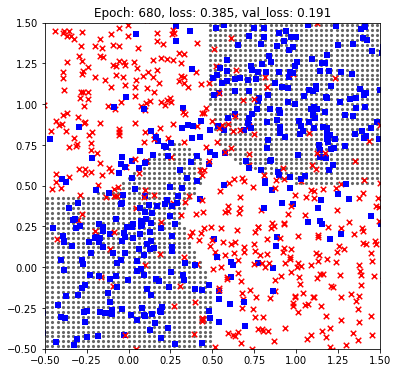

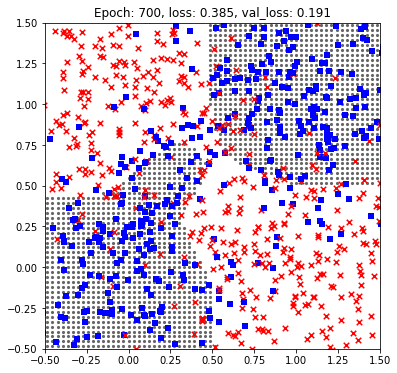

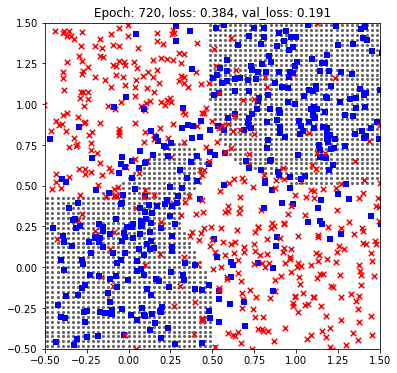

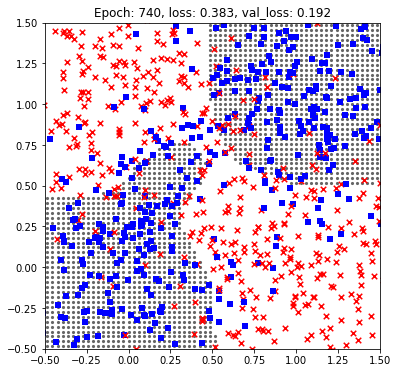

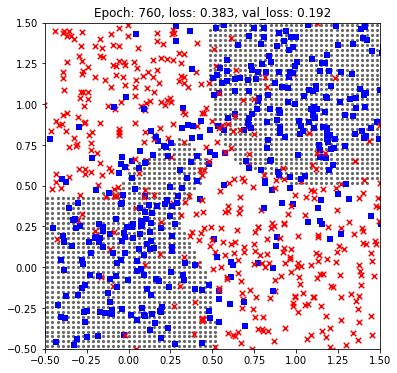

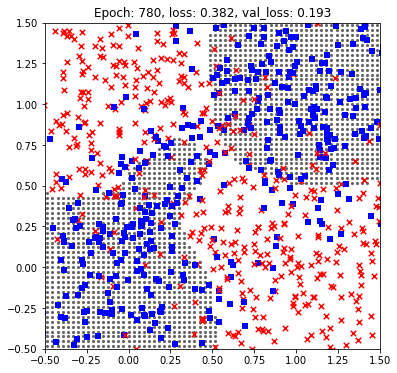

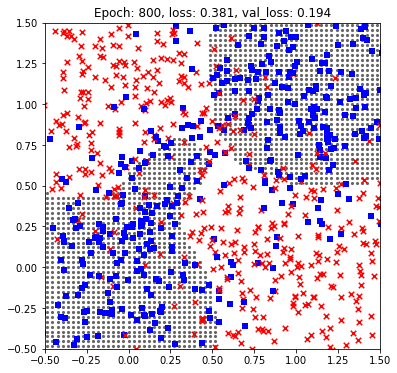

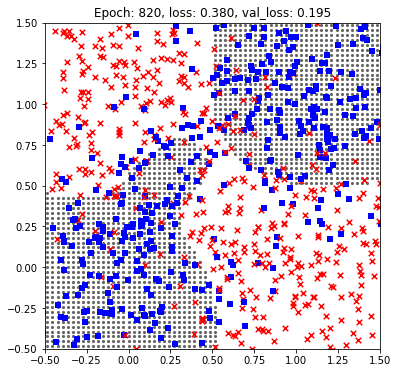

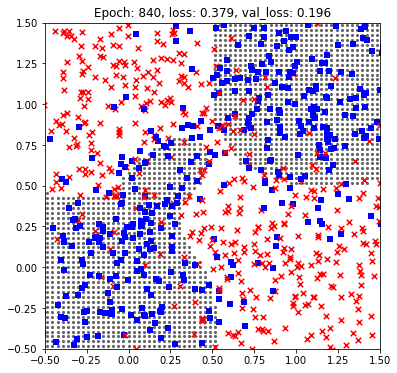

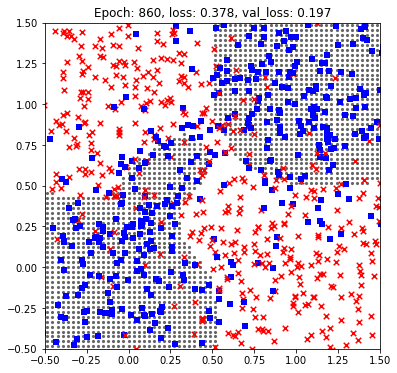

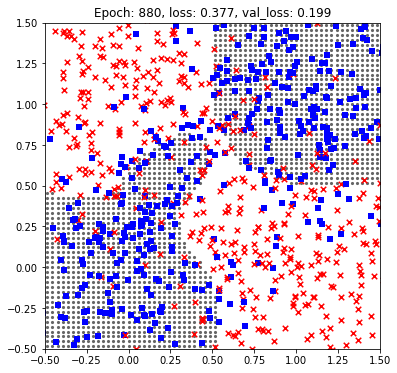

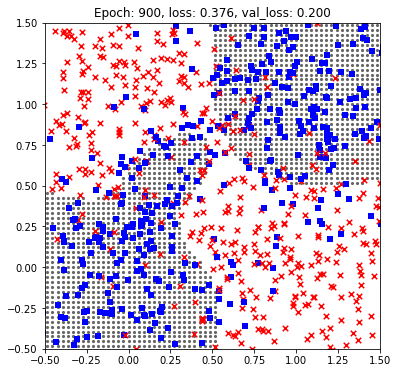

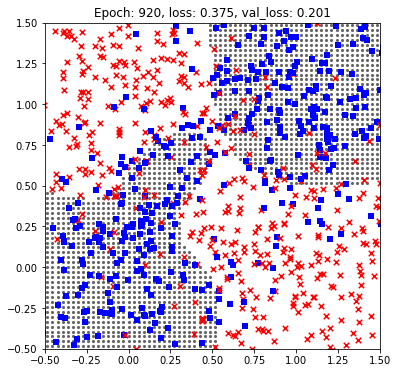

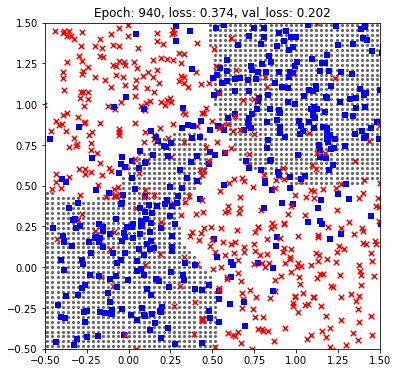

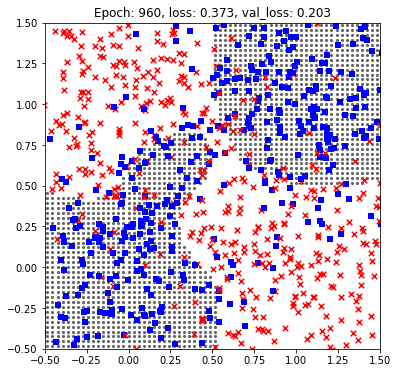

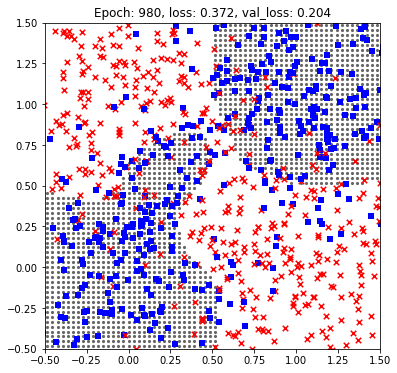

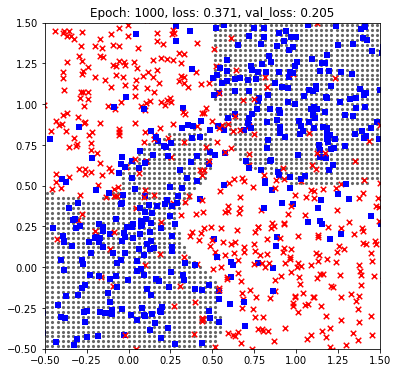

In [12]:
Xtrain, ttrain = getXORdata(sigma=0.4)
Xvalid, tvalid = getXORdata(sigma=0.2, number = 100)
display(Xtrain, ttrain)
plt.savefig("fig/traindata.png")
display(Xvalid, tvalid)
plt.savefig("fig/validdata.png")
log = train(build_nonlinear_model(), Xtrain, ttrain, Xvalid, tvalid, verbose=1, nb_epoch=1000)